# Align images in x-y plane

In [6]:
# %% load images
import os
import tifffile as tiff
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
# import ipywidgets as widgets
# from IPython.display import display

# Directory containing the images
directory = os.path.join('data', 'beads')

# List to hold image paths
image_paths = []

# Load the image paths
for filename in os.listdir(directory):
    if filename.endswith('.tif'):
        image_paths.append(os.path.join(directory, filename))

# Ensure there are images in the directory
if len(image_paths) == 0:
    raise ValueError("No TIFF images found in the directory.")

# Function to load the z-stack from a TIFF file
def load_z_stack(image_path):
    with tiff.TiffFile(image_path) as tif:
        z_stack = [page.asarray() for page in tif.pages]
    return z_stack

In [7]:
# display the image stacks side by side
# Load all z-stacks
z_stacks = [load_z_stack(image_path) for image_path in image_paths]

# Function to display slices side by side
def show_slices(slice_num):
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    for ax, z_stack, image_path in zip(axes, z_stacks, image_paths):
        ax.imshow(z_stack[slice_num], cmap='gray')
        ax.set_title(f"{os.path.basename(image_path)} - Slice {slice_num + 1}")
        ax.axis('off')
    plt.show()

# Determine the number of slices (assuming all stacks have the same number of slices)
num_slices = len(z_stacks[0])

# Create a slider
slider = IntSlider(min=0, max=num_slices - 1, step=1, value=0, description='Slice')

# Display the slices side by side
interact(show_slices, slice_num=slider)

interactive(children=(IntSlider(value=0, description='Slice', max=60), Output()), _dom_classes=('widget-intera…

<function __main__.show_slices(slice_num)>

In [8]:
import cv2
import numpy as np

def align_images(image_paths):
    # Load the first image to use as the reference
    ref_image = tiff.imread(image_paths[0])[0]
    
    # Initialize the list to hold aligned images
    aligned_images = [ref_image]
    
    # Iterate over the remaining images
    for image_path in image_paths[1:]:
        # Load the current image
        curr_image = tiff.imread(image_path)[0]
        
        # Convert images to grayscale
        ref_gray = cv2.cvtColor(ref_image, cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)
        
        # Detect ORB keypoints and descriptors
        orb = cv2.ORB_create()
        keypoints1, descriptors1 = orb.detectAndCompute(ref_gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(curr_gray, None)
        
        # Match descriptors using the BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors1, descriptors2)
        
        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)
        
        # Extract location of good matches
        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)
        
        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt
        
        # Find homography
        h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
        
        # Use homography to warp the current image
        height, width = ref_image.shape[:2]
        aligned_image = cv2.warpPerspective(curr_image, h, (width, height))
        
        # Append the aligned image to the list
        aligned_images.append(aligned_image)
    
    return aligned_images

# Align the images
aligned_images = align_images(image_paths)

# Function to display aligned slices side by side
def show_aligned_slices(slice_num):
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    for ax, aligned_image, image_path in zip(axes, aligned_images, image_paths):
        ax.imshow(aligned_image[slice_num], cmap='gray')
        ax.set_title(f"{os.path.basename(image_path)} - Slice {slice_num + 1}")
        ax.axis('off')
    plt.show()

# Display the aligned slices side by side
interact(show_aligned_slices, slice_num=slider)

error: OpenCV(4.10.0) D:\bld\libopencv_1723431319330\work\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x4931ec68::Set<1,-1,-1>,struct cv::impl::A0x4931ec68::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


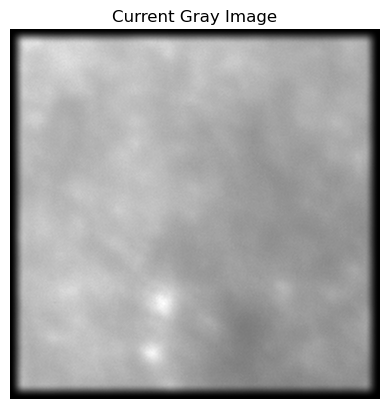

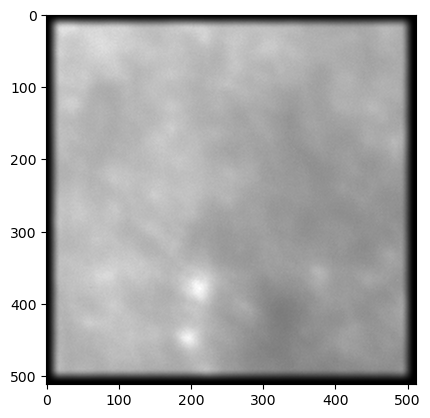

<Figure size 640x480 with 0 Axes>

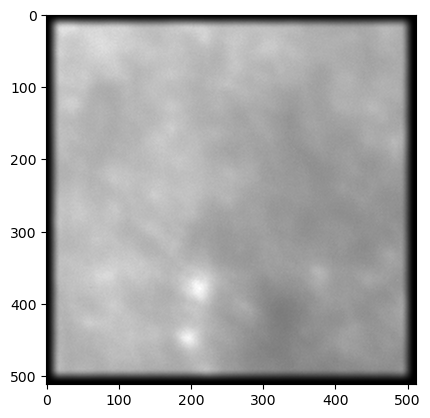

No keypoints detected in one or both images.


error: OpenCV(4.10.0) D:\bld\libopencv_1723431319330\work\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'


In [57]:
# Use the first z-stack as the reference
ref_stack = z_stacks[0]

# Initialize the list to hold aligned z-stacks
aligned_stacks = [ref_stack]

# Iterate over the remaining z-stacks
for stack in z_stacks[1:]:
    aligned_stack = []
    
    # Iterate over each slice in the z-stack
    for ref_slice, curr_slice in zip(ref_stack, stack):
        # Convert slices to grayscale
        ref_gray = ref_slice
        curr_gray = curr_slice

        # Normalize the image to the range [0, 255] if it's not already
        ref_gray_normalized = cv2.normalize(ref_gray, None, 0, 255, cv2.NORM_MINMAX)
        curr_gray_normalized = cv2.normalize(curr_gray, None, 0, 255, cv2.NORM_MINMAX)

        # Convert the image to uint8
        ref_gray_uint8 = ref_gray_normalized.astype(np.uint8)
        curr_gray_uint8 = curr_gray_normalized.astype(np.uint8)

        # Detect ORB keypoints and descriptors
        orb = cv2.ORB_create()
        keypoints1, descriptors1 = orb.detectAndCompute(ref_gray_uint8, None)
        keypoints2, descriptors2 = orb.detectAndCompute(curr_gray_uint8, None)

        if descriptors1 is None or descriptors2 is None:
            print("No keypoints detected in one or both images.")
            # Optionally: Append the unaligned slice or use a default transformation
            aligned_stack.append(curr_slice)  # Or handle as needed
            continue
        
        # Match descriptors using the BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors1, descriptors2)
        
        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)
        
        # Extract location of good matches
        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)
        
        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt
        
        # Find homography
        h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
        
        # Use homography to warp the current slice
        height, width = ref_slice.shape[:2]
        aligned_slice = cv2.warpPerspective(curr_slice, h, (width, height))
        
        # Append the aligned slice to the aligned stack
        aligned_stack.append(aligned_slice)
    
    # Append the aligned stack to the list of aligned stacks
    aligned_stacks.append(aligned_stack)
    
    break


In [ ]:
# %% load images
import os
import tifffile as tiff
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from IPython.display import display

# Directory containing the images
directory = os.path.join('data', 'beads')

# List to hold image paths
image_paths = []

# Load the image paths
for filename in os.listdir(directory):
    if filename.endswith('.tif'):
        image_paths.append(os.path.join(directory, filename))

# Ensure there are images in the directory
if len(image_paths) == 0:
    raise ValueError("No TIFF images found in the directory.")

# Function to load the z-stack from a TIFF file
def load_z_stack(image_path):
    with tiff.TiffFile(image_path) as tif:
        z_stack = [page.asarray() for page in tif.pages]
    return z_stack

In [ ]:
# display the image stacks side by side
# Load all z-stacks
z_stacks = [load_z_stack(image_path) for image_path in image_paths]

# Function to display slices side by side
def show_slices(slice_num):
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    for ax, z_stack, image_path in zip(axes, z_stacks, image_paths):
        ax.imshow(z_stack[slice_num], cmap='gray')
        ax.set_title(f"{os.path.basename(image_path)} - Slice {slice_num + 1}")
        ax.axis('off')
    plt.show()

# Determine the number of slices (assuming all stacks have the same number of slices)
num_slices = len(z_stacks[0])

# Create a slider
slider = IntSlider(min=0, max=num_slices - 1, step=1, value=0, description='Slice')

# Display the slices side by side
interact(show_slices, slice_num=slider)

interactive(children=(IntSlider(value=0, description='Slice', max=60), Output()), _dom_classes=('widget-intera…

<function __main__.show_slices(slice_num)>

### Normalization

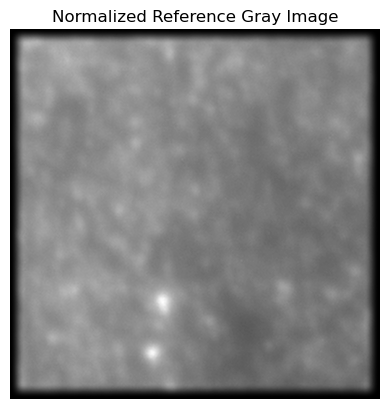

In [23]:
# Normalize the image to the range [0, 255] if it's not already
ref_gray_normalized = cv2.normalize(ref_gray, None, 0, 255, cv2.NORM_MINMAX)

# Convert the image to uint8
ref_gray_uint8 = ref_gray_normalized.astype(np.uint8)

# show image
plt.imshow(ref_gray_uint8, cmap='gray')
plt.title('Normalized Reference Gray Image')
plt.axis('off')  # Hide axis
plt.show()


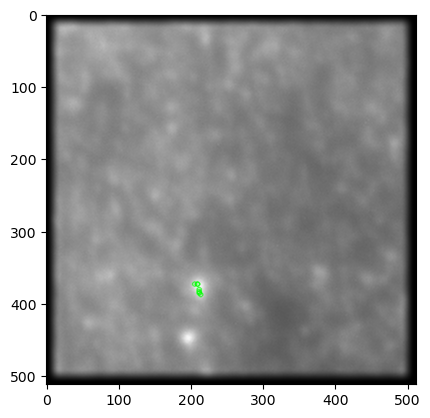

In [27]:
# Now you can use it with ORB
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(ref_gray_uint8, None)

# Optionally, visualize the keypoints
image_with_keypoints = cv2.drawKeypoints(ref_gray_uint8, keypoints, None, color=(0, 255, 0))
plt.imshow(image_with_keypoints, cmap='gray')
plt.show()

In [29]:
print(descriptors1.dtype)

uint8


### Descriptors

In [42]:
# Normalize the image to the range [0, 255] if it's not already
ref_gray_normalized = cv2.normalize(ref_gray, None, 0, 255, cv2.NORM_MINMAX)
curr_gray_normalized = cv2.normalize(curr_gray, None, 0, 255, cv2.NORM_MINMAX)

# Convert the image to uint8
ref_gray_uint8 = ref_gray_normalized.astype(np.uint8)
curr_gray_uint8 = curr_gray_normalized.astype(np.uint8)

# Detect ORB keypoints and descriptors
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(ref_gray_uint8, None)
keypoints2, descriptors2 = orb.detectAndCompute(curr_gray_uint8, None)

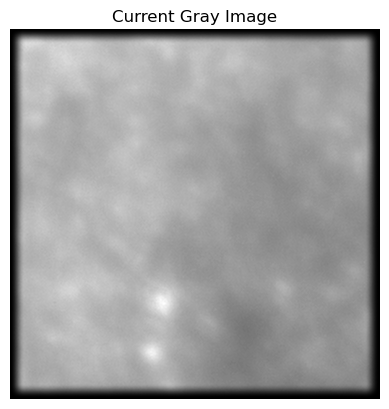

In [37]:
plt.imshow(curr_gray_uint8, cmap='gray')
plt.title('Current Gray Image')
plt.axis('off')  # Hide axis
plt.show()

In [45]:
print(descriptors1.dtype, descriptors2.dtype)

uint8 uint8


In [46]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

In [48]:
# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

In [49]:
# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography to warp the current slice
height, width = ref_slice.shape[:2]
aligned_slice = cv2.warpPerspective(curr_slice, h, (width, height))

error: OpenCV(4.10.0) D:\bld\libopencv_1723431319330\work\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'


In [51]:
ref_slice.shape[:2]
len(points1), len(points2)


(512, 512)

## Gathering only a pair of images

### Choose images

In [62]:
plane1_stack = z_stacks[0]
plane2_stack = z_stacks[1]


In [63]:
plane1_slice1 = plane1_stack[0]
plane2_slice1 = plane2_stack[0]

In [103]:
# Normalize the image to the range [0, 255] if it's not already
plane1_slice1_normalized = cv2.normalize(plane1_slice1, None, 0, 255, cv2.NORM_MINMAX)
plane2_slice1_normalized = cv2.normalize(plane2_slice1, None, 0, 255, cv2.NORM_MINMAX)

# Convert the image to uint8
plane1_slice1_uint8 = plane1_slice1_normalized.astype(np.uint8)
plane2_slice1_uint8 = plane2_slice1_normalized.astype(np.uint8)

# Rename
plane1_slice1 = plane1_slice1_uint8
plane2_slice1 = plane2_slice1_uint8



### Align images


In [80]:
kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])  # A simple sharpening filter
plane2_slice1_sharpened = cv2.filter2D(plane2_slice1, -1, kernel)
keypoints2, descriptors2 = orb.detectAndCompute(plane2_slice1_sharpened, None)

plane2_slice1 = plane2_slice1_sharpened


In [90]:
# # Step 1: Detect ORB keypoints and descriptors
# orb = cv2.ORB_create()

# Initialize ORB with adjusted parameters
orb = cv2.ORB_create(nfeatures=2000, scaleFactor=1.2, edgeThreshold=15)

keypoints1, descriptors1 = orb.detectAndCompute(plane1_slice1, None)
keypoints2, descriptors2 = orb.detectAndCompute(plane2_slice1, None)

# Step 2: Match descriptors using the BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Step 3: Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Step 4: Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Step 5: Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

if h is None:
    print("Homography could not be computed.")
    # Handle the error, perhaps by skipping this alignment
else:
   pass

# Step 6: Use homography to warp plane2_slice1 to align with plane1_slice1
height, width = plane1_slice1.shape
aligned_plane2_slice1 = cv2.warpPerspective(plane2_slice1, h, (width, height))

# Step 7: Display the aligned images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Plane 1 Slice 1')
plt.imshow(plane1_slice1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Plane 2 Slice 1 (Before Alignment)')
plt.imshow(plane2_slice1, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Plane 2 Slice 1 (After Alignment)')
plt.imshow(aligned_plane2_slice1, cmap='gray')

plt.show()

Homography could not be computed.


error: OpenCV(4.10.0) D:\bld\libopencv_1723431319330\work\modules\imgproc\src\imgwarp.cpp:3400: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'cv::warpPerspective'


In [85]:
len(matches)

5

In [72]:
plane2_slice1_enhanced = cv2.equalizeHist(plane2_slice1)
keypoints2, descriptors2 = orb.detectAndCompute(plane2_slice1_enhanced, None)


In [75]:
kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])  # A simple sharpening filter
plane2_slice1_sharpened = cv2.filter2D(plane2_slice1, -1, kernel)
keypoints2, descriptors2 = orb.detectAndCompute(plane2_slice1_sharpened, None)


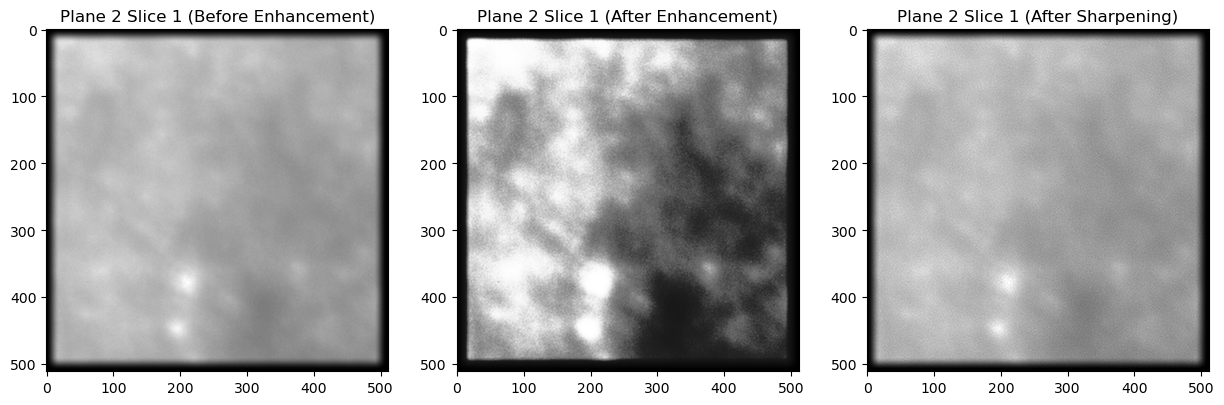

In [77]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Plane 2 Slice 1 (Before Enhancement)')
plt.imshow(plane2_slice1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Plane 2 Slice 1 (After Enhancement)')
plt.imshow(plane2_slice1_enhanced, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Plane 2 Slice 1 (After Sharpening)')
plt.imshow(plane2_slice1_sharpened, cmap='gray')

plt.show()


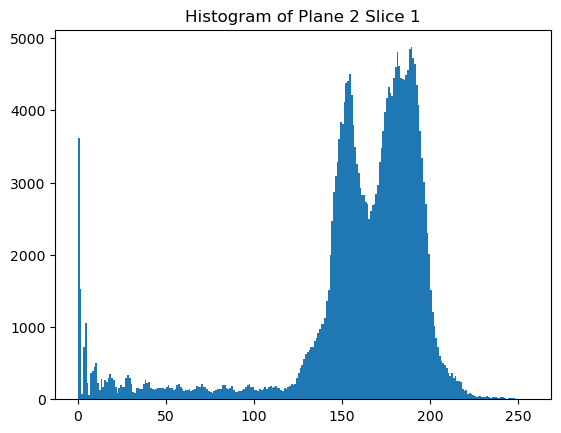

In [78]:
plt.hist(plane2_slice1.ravel(), 256, [0, 256])
plt.title('Histogram of Plane 2 Slice 1')
plt.show()


In [87]:
print(h)

None


In [93]:
# Filter matches by distance (optional step)
good_matches = [m for m in matches if m.distance < 100]  # Adjust the threshold as needed

if len(good_matches) >= 4:
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
    h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
else:
    print("Not enough good matches to compute homography.")


### Plot keypoints and matches

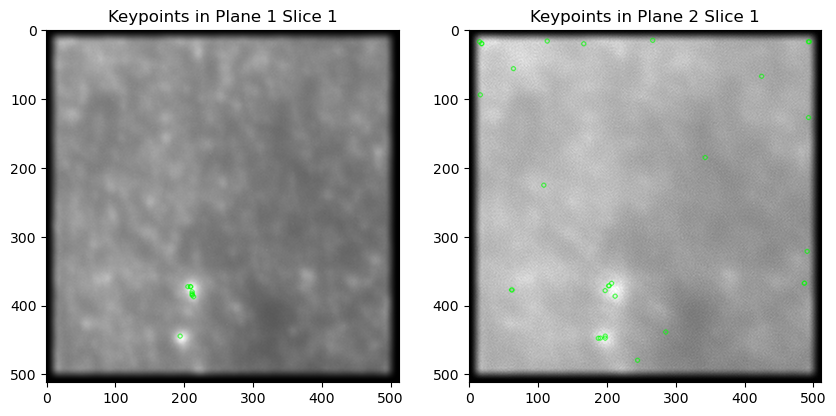

In [95]:
# Plot keypoints on both images
img_keypoints1 = cv2.drawKeypoints(plane1_slice1, keypoints1, None, color=(0, 255, 0))
img_keypoints2 = cv2.drawKeypoints(plane2_slice1, keypoints2, None, color=(0, 255, 0))

# Display keypoints
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Keypoints in Plane 1 Slice 1')
plt.imshow(img_keypoints1, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Keypoints in Plane 2 Slice 1')
plt.imshow(img_keypoints2, cmap='gray')

plt.show()

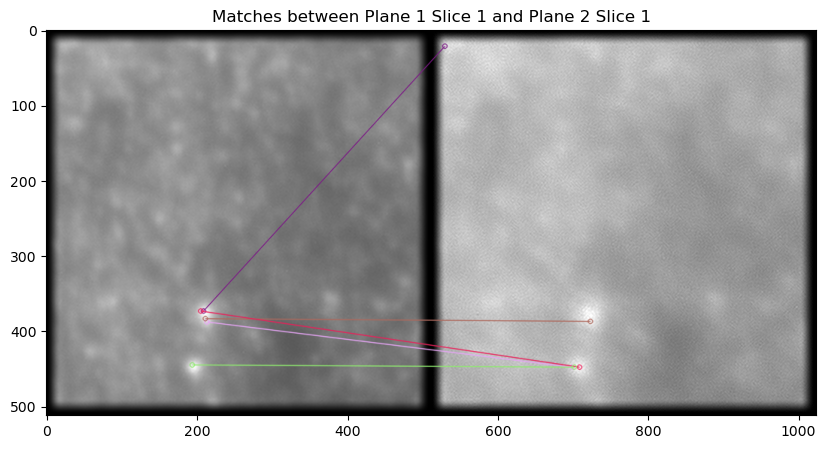

In [96]:
# Plot matches between the two images
img_matches = cv2.drawMatches(plane1_slice1, keypoints1, plane2_slice1, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matches
plt.figure(figsize=(15, 5))
plt.title('Matches between Plane 1 Slice 1 and Plane 2 Slice 1')
plt.imshow(img_matches)
plt.show()


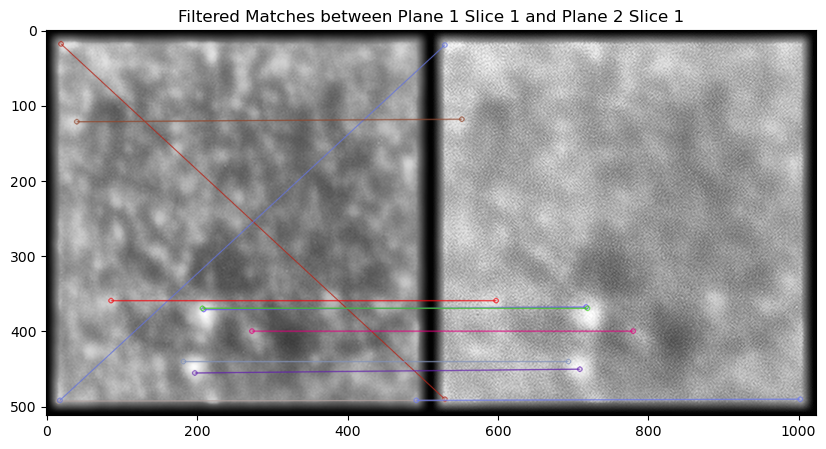

In [104]:
# Apply CLAHE to improve contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
plane1_slice1_clahe = clahe.apply(plane1_slice1)
plane2_slice1_clahe = clahe.apply(plane2_slice1)

# Initialize ORB with adjusted parameters
orb = cv2.ORB_create(nfeatures=3000, scaleFactor=1.5, edgeThreshold=10)

# Detect ORB keypoints and descriptors again
keypoints1, descriptors1 = orb.detectAndCompute(plane1_slice1_clahe, None)
keypoints2, descriptors2 = orb.detectAndCompute(plane2_slice1_clahe, None)

# Match descriptors using the BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance and filter them
matches = sorted(matches, key=lambda x: x.distance)
good_matches = [m for m in matches if m.distance < 30]  # Adjust the threshold

# Plot keypoints and matches
img_matches = cv2.drawMatches(plane1_slice1_clahe, keypoints1, plane2_slice1_clahe, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 5))
plt.title('Filtered Matches between Plane 1 Slice 1 and Plane 2 Slice 1')
plt.imshow(img_matches)
plt.show()

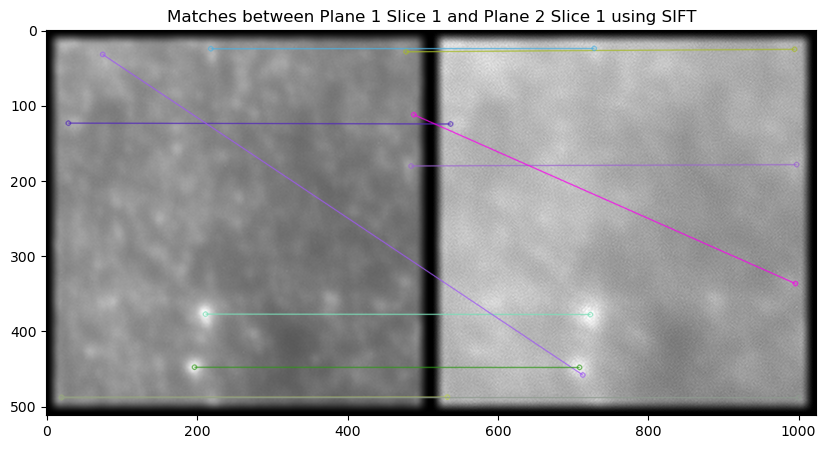

In [105]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect SIFT keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(plane1_slice1, None)
keypoints2, descriptors2 = sift.detectAndCompute(plane2_slice1, None)

# Match descriptors using BFMatcher with Euclidean distance (default for SIFT)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Plot keypoints and matches
img_matches = cv2.drawMatches(plane1_slice1, keypoints1, plane2_slice1, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 5))
plt.title('Matches between Plane 1 Slice 1 and Plane 2 Slice 1 using SIFT')
plt.imshow(img_matches)
plt.show()


#### Ratio Test with KNN Matching

Good matches after ratio test: 9


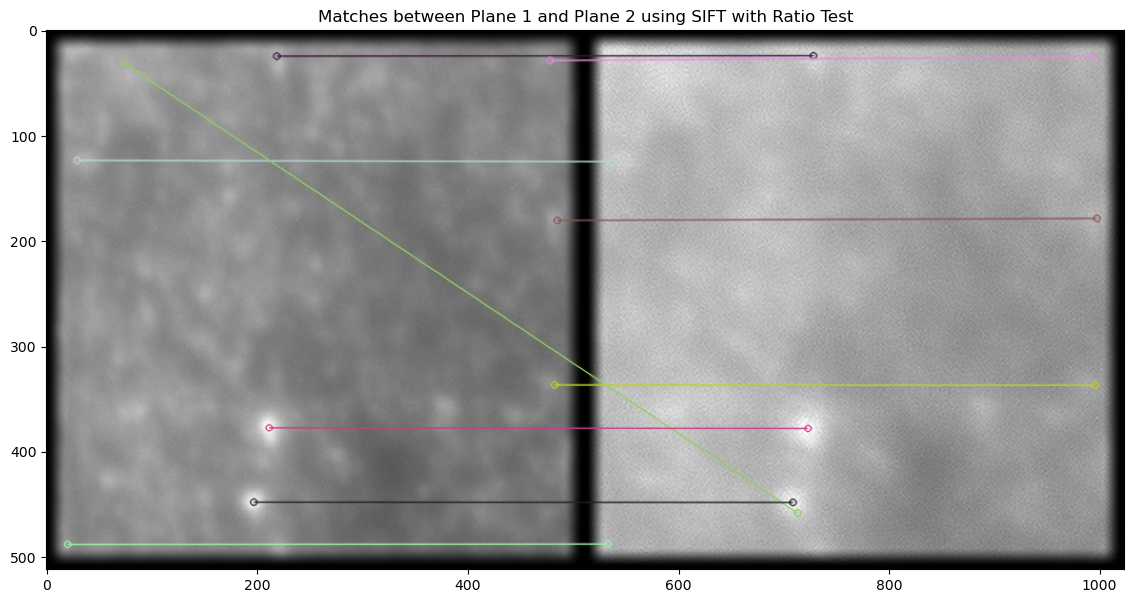

In [108]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(plane1_slice1, None)
keypoints2, descriptors2 = sift.detectAndCompute(plane2_slice1, None)

# Match descriptors using BFMatcher with KNN (k=2)
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test
ratio_threshold = 0.80
good_matches = []
for m, n in matches:
    if m.distance < ratio_threshold * n.distance:
        good_matches.append(m)

print(f'Good matches after ratio test: {len(good_matches)}')

# Visualize the matches
img_matches = cv2.drawMatches(
    plane1_slice1, keypoints1,
    plane2_slice1, keypoints2,
    good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(15, 7))
plt.title('Matches between Plane 1 and Plane 2 using SIFT with Ratio Test')
plt.imshow(img_matches)
plt.show()

Further Filtering Based on Spatial Distance

Filtered matches within distance threshold: 8


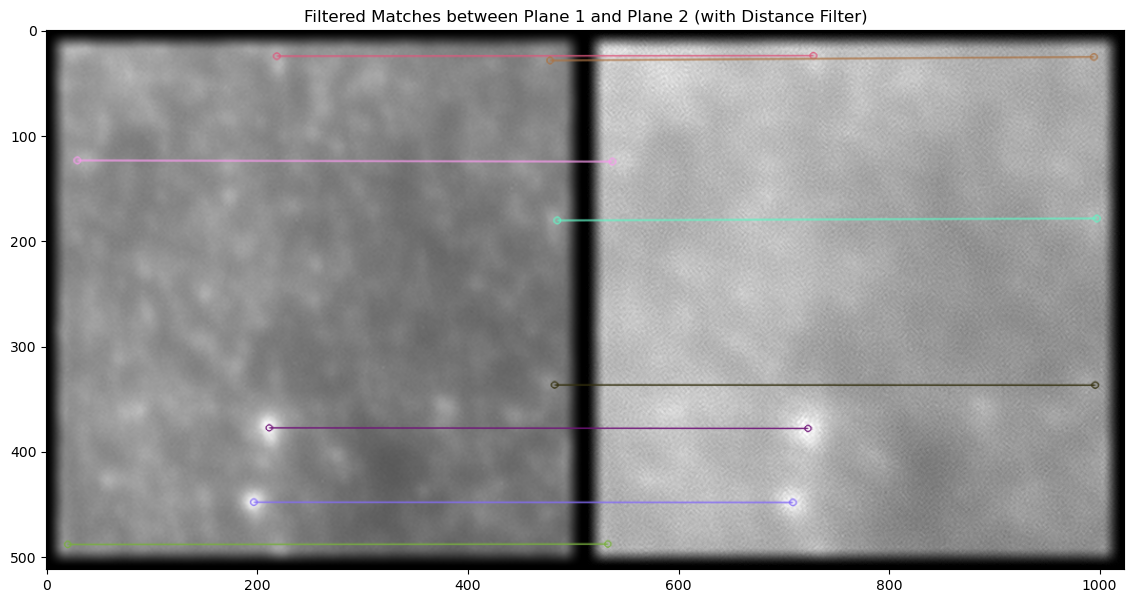

In [109]:
# Define a maximum allowed distance between matched points
max_distance = 100  # You can adjust this threshold

filtered_matches = []
for match in good_matches:
    pt1 = keypoints1[match.queryIdx].pt
    pt2 = keypoints2[match.trainIdx].pt
    distance = np.linalg.norm(np.array(pt1) - np.array(pt2))
    if distance < max_distance:
        filtered_matches.append(match)

print(f'Filtered matches within distance threshold: {len(filtered_matches)}')

# Visualize filtered matches
img_filtered_matches = cv2.drawMatches(
    plane1_slice1, keypoints1,
    plane2_slice1, keypoints2,
    filtered_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(15, 7))
plt.title('Filtered Matches between Plane 1 and Plane 2 (with Distance Filter)')
plt.imshow(img_filtered_matches)
plt.show()


### Homography Estimation with RANSAC

Homography matrix:
[[ 9.87374164e-01 -1.35273378e-02  5.38133559e+00]
 [ 8.31404954e-03  9.80058454e-01 -1.52406953e-02]
 [ 1.13501878e-05 -4.19190379e-05  1.00000000e+00]]


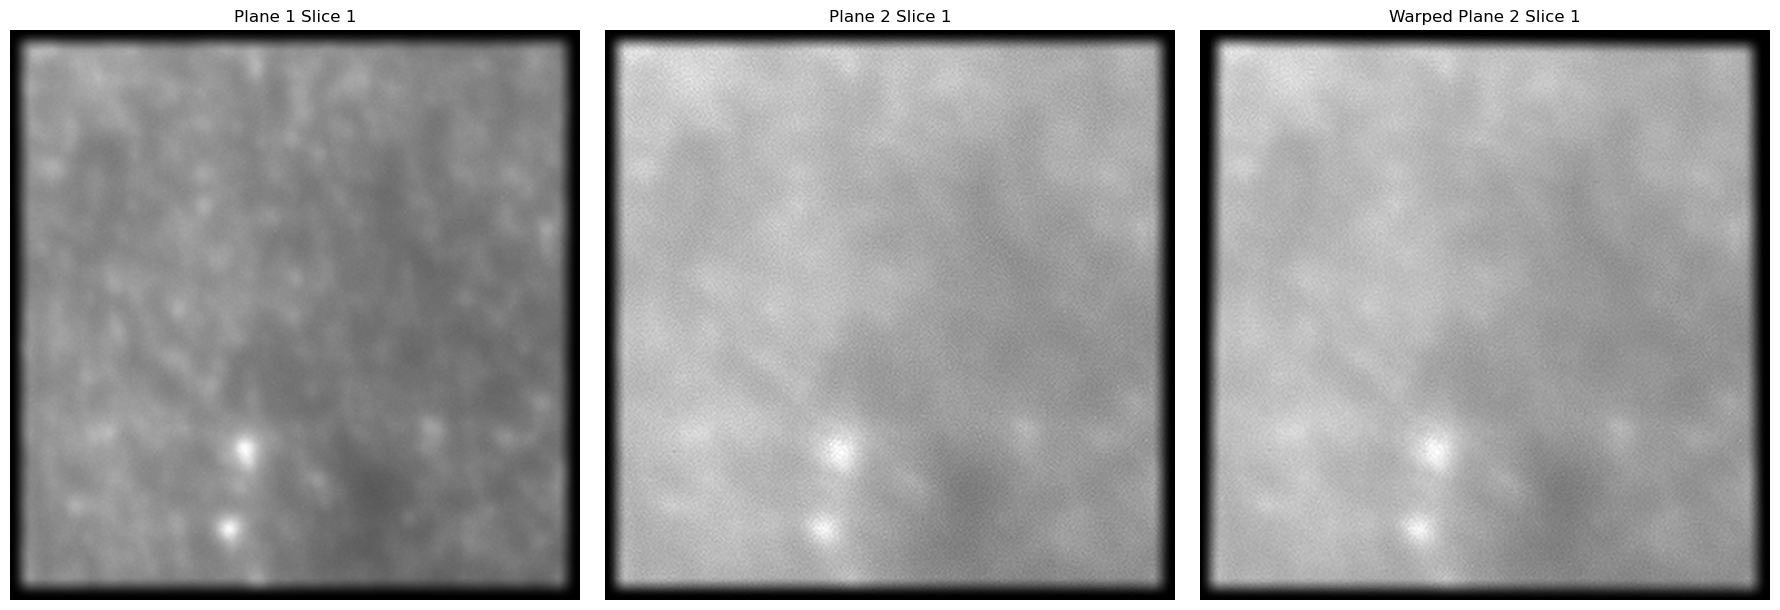

In [110]:
if len(filtered_matches) >= 4:
    # Extract location of good matches
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in filtered_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in filtered_matches]).reshape(-1, 1, 2)

    # Compute homography using RANSAC
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    matches_mask = mask.ravel().tolist()

    print('Homography matrix:')
    print(H)

    # Warp the second image using the homography matrix
    height, width = plane1_slice1.shape
    warped_plane2 = cv2.warpPerspective(plane2_slice1, H, (width, height))

    # Visualize the aligned images
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title('Plane 1 Slice 1')
    plt.imshow(plane1_slice1, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Plane 2 Slice 1')
    plt.imshow(plane2_slice1, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Warped Plane 2 Slice 1')
    plt.imshow(warped_plane2, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough matches are found to compute a reliable homography.")


Examining the extent of the warping

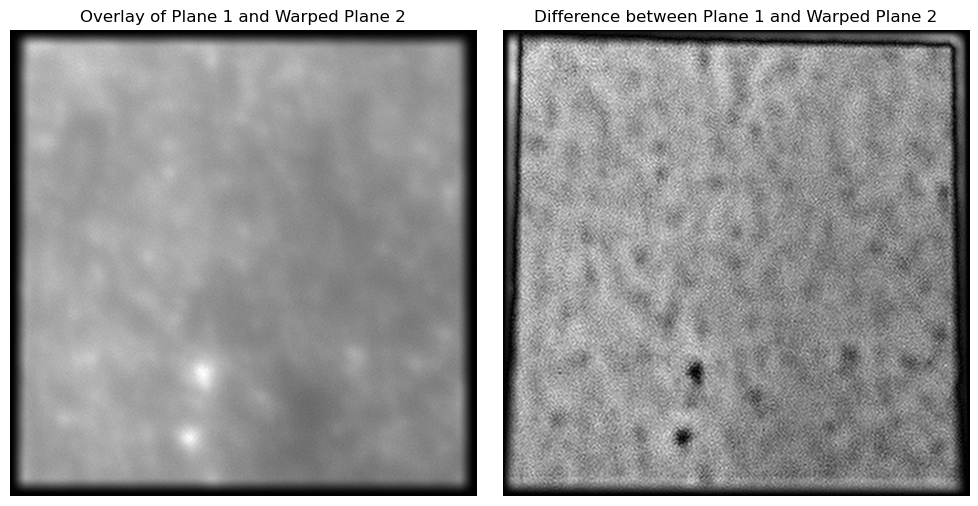

In [118]:
# Assuming you have already computed `warped_plane2` and `plane1_slice1`

# Overlay the warped image on top of the original
overlay = cv2.addWeighted(plane1_slice1, 0.5, warped_plane2, 0.5, 0)

# Compute the absolute difference between the original and warped images
difference = cv2.absdiff(plane1_slice1, warped_plane2)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Overlay of Plane 1 and Warped Plane 2')
plt.imshow(overlay, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Difference between Plane 1 and Warped Plane 2')
plt.imshow(difference, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


Displacement of keypoints after warping:
Keypoint 0: Displacement = 0.09 pixels
Keypoint 1: Displacement = 0.57 pixels
Keypoint 2: Displacement = 0.39 pixels
Keypoint 3: Displacement = 0.25 pixels
Keypoint 4: Displacement = 0.85 pixels
Keypoint 5: Displacement = 1.30 pixels
Keypoint 6: Displacement = 0.49 pixels
Keypoint 7: Displacement = 1.87 pixels


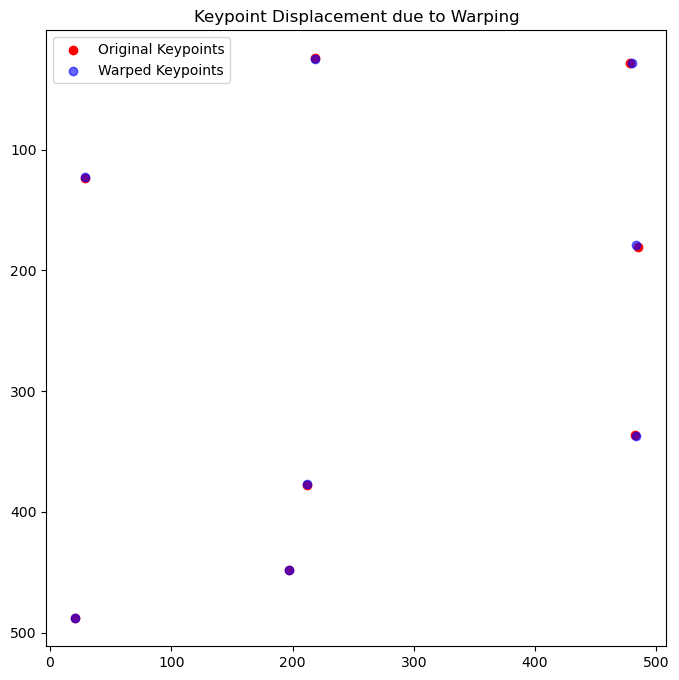

In [115]:
# Calculate the displacement of keypoints due to warping
if len(filtered_matches) >= 4:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in filtered_matches]).reshape(-1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in filtered_matches]).reshape(-1, 2)

    # Apply the homography to the original keypoints in plane2_slice1
    warped_keypoints = cv2.perspectiveTransform(dst_pts.reshape(-1, 1, 2), H).reshape(-1, 2)

    # Calculate the displacement
    displacement = np.linalg.norm(warped_keypoints - src_pts, axis=1)

    print('Displacement of keypoints after warping:')
    for i, d in enumerate(displacement):
        print(f'Keypoint {i}: Displacement = {d:.2f} pixels')

    # Visualize the keypoints before and after warping
    plt.figure(figsize=(8, 8))
    plt.scatter(src_pts[:, 0], src_pts[:, 1], color='red', label='Original Keypoints')
    plt.scatter(warped_keypoints[:, 0], warped_keypoints[:, 1], color='blue', label='Warped Keypoints', alpha=0.6)
    plt.legend()
    plt.title('Keypoint Displacement due to Warping')
    plt.gca().invert_yaxis()  # Invert y-axis for better visual comparison
    plt.show()
